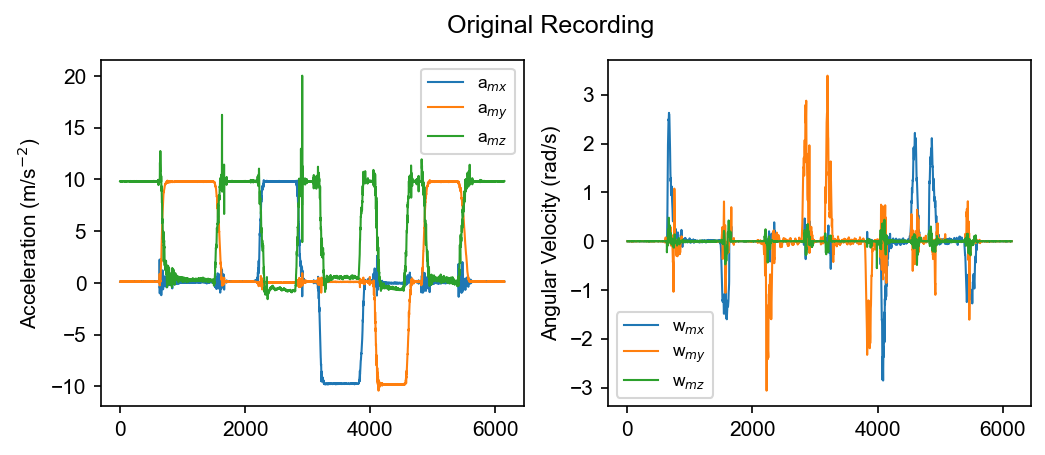

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

fs = 100 # sampling frequency

acc = pd.read_csv('./data/Accelerometer_Phone_Rotation.csv').iloc[:, 1:].to_numpy()
gyr = pd.read_csv('./data/Gyroscope_Phone_Rotation.csv').iloc[:, 1:].to_numpy()

fig, ax = plt.subplots(1, 2, figsize=(8,3), dpi=150)
fig.suptitle('Original Recording')
ax[0].plot(acc, lw=1, label=['a$_{mx}$', 'a$_{my}$', 'a$_{mz}$'])
ax[1].plot(gyr, lw=1, label=['w$_{mx}$', 'w$_{my}$', 'w$_{mz}$'])
ax[0].legend(fontsize='small')
ax[0].set_ylabel('Acceleration (m/s$^{-2}$)')
ax[1].legend(fontsize='small')
ax[1].set_ylabel('Angular Velocity (rad/s)')
plt.show()

# Test dynamic Gravity Removal

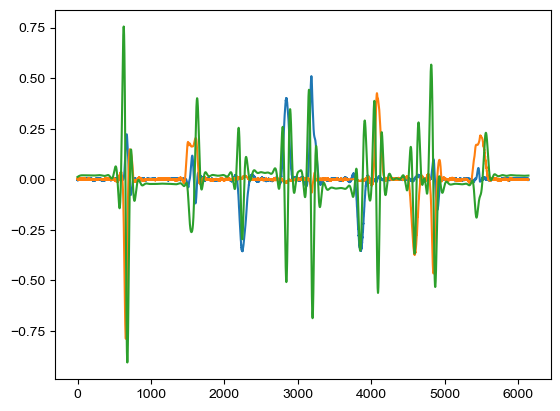

In [2]:
from signal_processing import bwfilt
from orientation import get_linear_acceleration
acc_f, gyr_f = bwfilt(acc, 4, 1, fs), bwfilt(gyr, 4, 1, fs)
a_I = get_linear_acceleration(a_m=acc_f, w_m=gyr_f, fs=fs, g_global=np.array([0, 0, 9.81]))
plt.plot(a_I)
plt.show()

### I can see from here that there is something wrong with the initial orientation, as the acceleration should be 0
#### Need to apply Rodrigues Rotation Formula

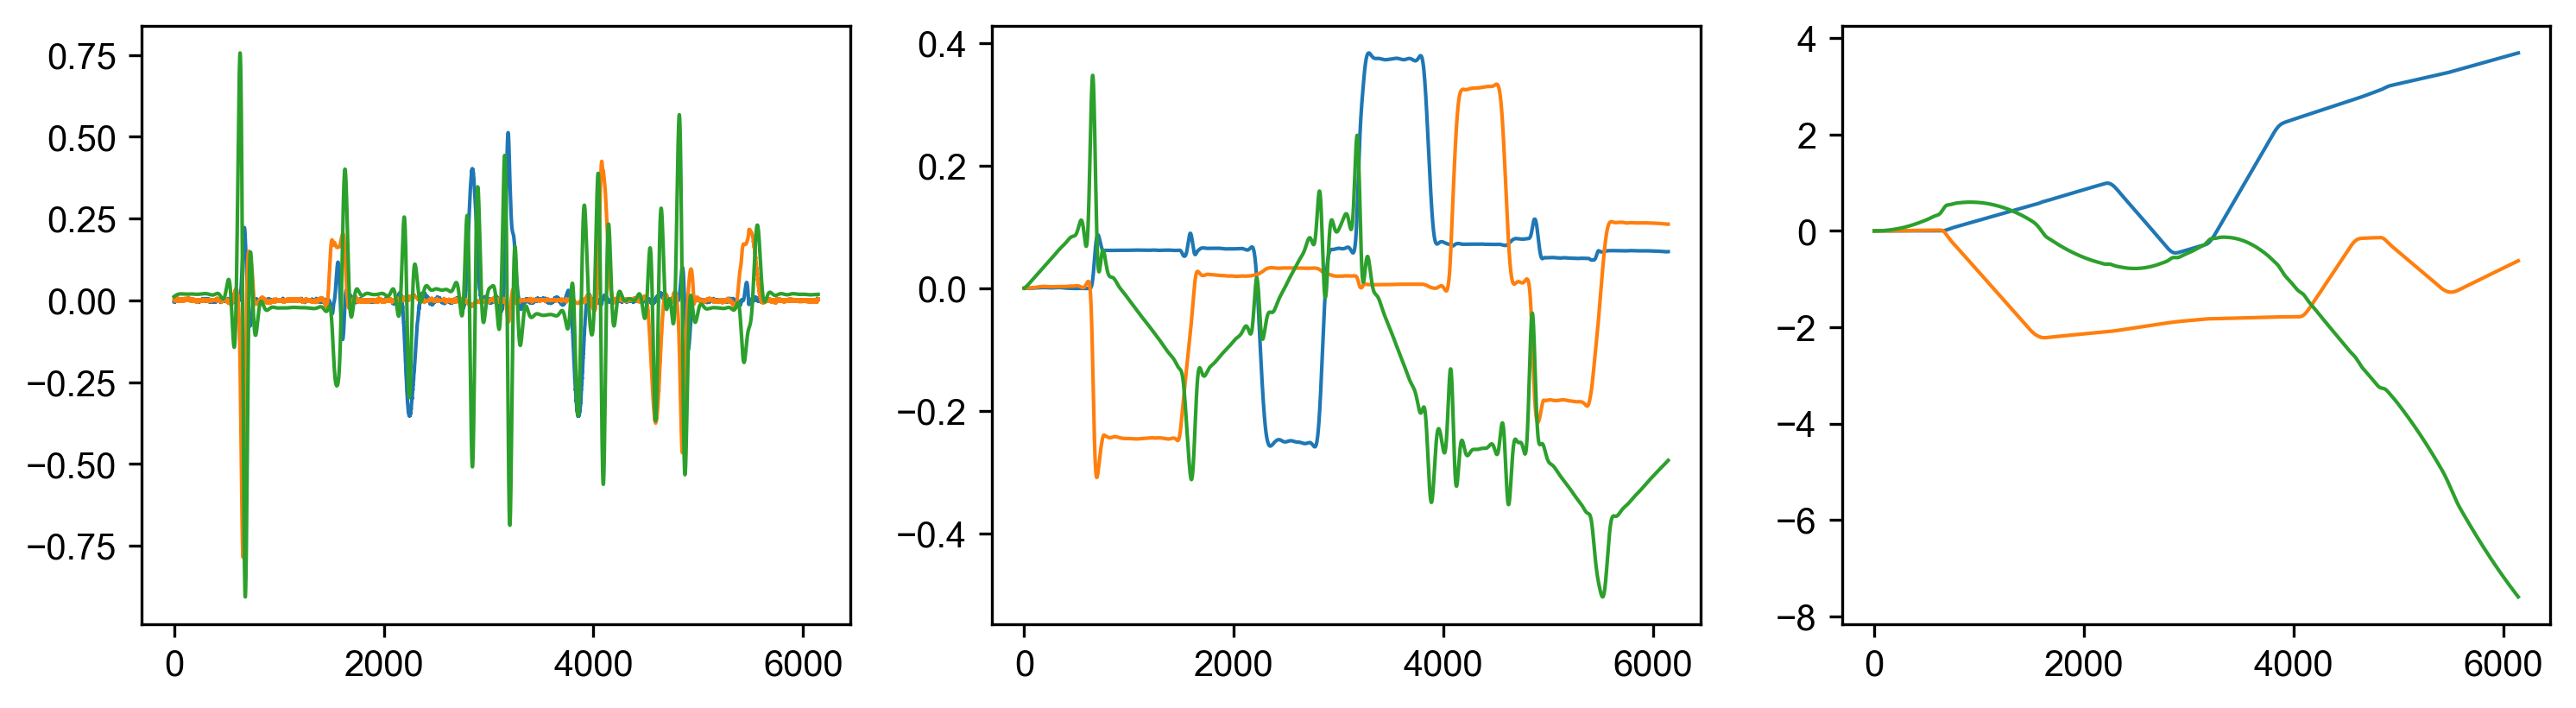

In [7]:
from orientation import rodrigues_rotation
from signal_processing import integrate_ndim

g_global = np.array([0, 0, 9.81])
g_sensor = np.mean(acc[:100, :], axis=0)
R = rodrigues_rotation(g_sensor=g_sensor, g_global=g_global)

a_m = (R @ acc.T).T
w_m = (R @ gyr.T).T
w_m -= np.mean(w_m[:100, :], axis=0) # Remove gyroscope bias as well

a_m, w_m = bwfilt(a_m, 4, 1, fs), bwfilt(w_m, 4, 1, fs)

a_I = get_linear_acceleration(a_m=a_m, w_m=w_m, fs=fs, g_global=g_global)
v_I = integrate_ndim(y_prime=a_I, fs=fs)
d_I = integrate_ndim(y_prime=v_I, fs=fs)
_, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=300)
ax[0].plot(a_I, lw=1)
ax[1].plot(v_I, lw=1)
ax[2].plot(d_I, lw=1)
plt.show()
